<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# !pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
scipy 1.4.1
pandas 1.0.5
matplotlib 3.2.2
statsmodels 0.10.2
sklearn 0.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA =  '/content/' 

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

Пример:

In [7]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users.todense(), y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [8]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

train_score = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
print('train_score:', train_score.mean())

knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
valid_score = accuracy_score(y_valid, y_pred)
print('valid_score:', valid_score)

train_score: 0.5616746022306306
valid_score: 0.5894761791893813


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [9]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [ ]:
write_answer_to_file('{} {}'.format(round(train_score.mean(), 3), round(valid_score, 3)), 
                     'answer4_1.txt')

In [ ]:
!cat answer4_1.txt

0.562 0.589

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17, n_jobs=-1)
forest.fit(X_train, y_train)

oob_score = forest.oob_score_
print('oob_score:', oob_score)
 
valid_score = accuracy_score(y_valid, forest.predict(X_valid))
print('valid_score:', valid_score)

oob_score: 0.7221093273724852
valid_score: 0.7293197440151695


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
write_answer_to_file('{} {}'.format(round(oob_score, 3), round(valid_score, 3)),
                     'answer4_2.txt')

In [ ]:
!cat answer4_2.txt

0.722 0.729

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

train_score = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy')
print('train_score:', train_score.mean())

logit.fit(X_train, y_train)
y_pred = logit.predict(X_valid)
valid_score = accuracy_score(y_valid, y_pred)
print('valid_score:', valid_score)

train_score: 0.7606189739891912
valid_score: 0.7767243422611994


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [ ]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, n_jobs=-1, multi_class='multinomial', random_state=17) 
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 55.1 s, sys: 2.9 s, total: 58 s
Wall time: 5min 43s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [ ]:
logit_mean_cv_scores1 = np.array(list(logit_grid_searcher1.scores_.values())[0]).mean(axis = 0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_score1 = max(logit_mean_cv_scores1)
best_C1 = logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]
print('The best cross_val_score:', best_score1)
print('With parameter C:', best_C1)

The best cross_val_score: 0.7613302322066194
With parameter C: 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

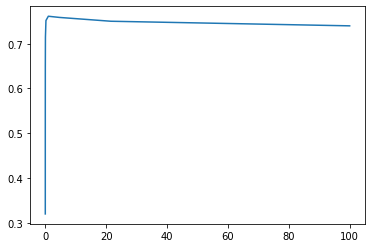

In [ ]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [ ]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, n_jobs=-1, multi_class='multinomial', random_state=17) 
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 57.7 s, sys: 3.02 s, total: 1min
Wall time: 16min 26s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [ ]:
logit_mean_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values())[0]).mean(axis = 0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_score2 = max(logit_mean_cv_scores2)
best_C2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]
print('The best cross_val_score:', best_score2)
print('With parameter C:', best_C2)

The best cross_val_score: 0.761330294154816
With parameter C: 1.9157894736842107


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

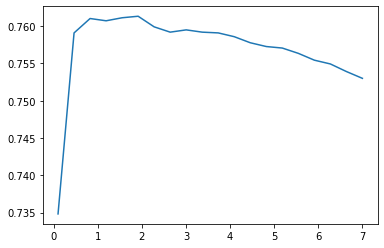

In [ ]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [ ]:
logit_grid_searcher2.set_params(Cs = best_C2)
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
print(logit_cv_acc)

0.7798056411471913


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
print('train_score:', best_score2)
print('valid_score:', logit_cv_acc)

train_score: 0.761330294154816
valid_score: 0.7798056411471913


In [ ]:
write_answer_to_file('{} {}'.format(round(best_score2, 3), round(logit_cv_acc, 3)), 
                     'answer4_3.txt')

In [ ]:
!cat answer4_3.txt

0.761 0.78

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [56]:
from sklearn.svm import LinearSVC

In [ ]:
svm = LinearSVC(C=1.0, random_state=17)
train_score = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy')
print('train_score:', train_score.mean())

svm.fit(X_train, y_train)
y_pred = svm.predict(X_valid)
valid_score = accuracy_score(y_valid, y_pred)
print('valid_score:', valid_score)

train_score: 0.7508655711747608
valid_score: 0.7769613652524295


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [ ]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=svm, param_grid=svm_params1, scoring='accuracy', n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 22.5 s, sys: 4.2 s, total: 26.7 s
Wall time: 1min 30s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_score3 = svm_grid_searcher1.best_score_
best_C3 = svm_grid_searcher1.best_params_
print('The best cross_val_score:', best_score3)
print('With parameter:', best_C3)

The best cross_val_score: 0.6868546856376824
With parameter: {'C': 2222.2223000000004}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

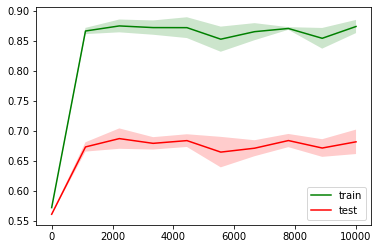

In [ ]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [59]:
%%time
svm = LinearSVC(random_state=17)
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(estimator=svm, param_grid=svm_params2, scoring='accuracy', n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 33.3 s, total: 1min 48s
Wall time: 4min 30s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_score4 = svm_grid_searcher2.best_score_
best_C4 = svm_grid_searcher2.best_params_
print('The best cross_val_score:', best_score4)
print('With parameter:', best_C4)

The best cross_val_score: 0.7670206386611259
With parameter: {'C': 0.10434482758620689}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

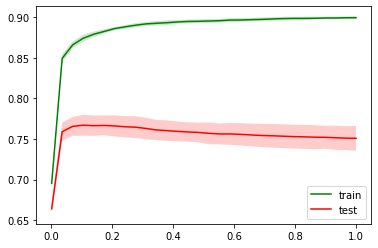

In [ ]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [ ]:
svm = LinearSVC(C=best_C4['C'], random_state=17)
svm.fit(X_train, y_train)
svm_cv_acc = accuracy_score(y_valid, svm.predict(X_valid))
print(svm_cv_acc)

0.7807537331121118


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
print('train_score:', best_score4)
print('valid_score:', svm_cv_acc)

train_score: 0.7670206386611259
valid_score: 0.7807537331121118


In [ ]:
write_answer_to_file('{} {}'.format(round(best_score4, 3), round(svm_cv_acc, 3)), 
                     'answer4_4.txt')

In [ ]:
!cat answer4_4.txt

0.767 0.781

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [70]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''

    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
      X_sparse = pickle.load(X_sparse_pkl)
      # X_sparse = pickle.load(X_sparse_pkl).todense()

    with open(path_to_y_pickle, 'rb') as y_pkl:
      y = pickle.load(y_pkl)

    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

    train_score = cross_val_score(estimator, X_train, y_train, cv=skf, scoring='accuracy').mean()
    # print('train_score:', train_score)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_valid)
    valid_score = accuracy_score(y_valid, y_pred)
    # print('valid_score:', valid_score)

    return (train_score, valid_score)

**Убедитесь, что функция работает.**

In [15]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [12]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [30]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:

        path_to_X_pkl = os.path.join(PATH_TO_DATA,
                                     'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        
        path_to_y_pkl = os.path.join(PATH_TO_DATA,
                                     'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        
        print('\ns{}_w{}:\n'.format(session_length, window_size), model_assessment(estimator, 
                               path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3), '\n')

1it [00:05,  5.72s/it]


s15_w10:
 (0.8243252292702751, 0.8404835269021095) 



2it [00:09,  5.26s/it]


s10_w10:
 (0.7670206386611259, 0.7807537331121118) 



5it [00:17,  4.46s/it]


s15_w7:
 (0.8495024256089474, 0.8543222166915547) 



6it [00:23,  4.84s/it]


s10_w7:
 (0.7983645917156946, 0.8073668491786958) 



7it [00:28,  4.77s/it]


s7_w7:
 (0.754765400423003, 0.7617388418782147) 



9it [00:39,  5.02s/it]


s15_w5:
 (0.8670355547005402, 0.8752963489805595) 



10it [00:47,  5.94s/it]


s10_w5:
 (0.8177520250854086, 0.8245614035087719) 



11it [00:53,  6.09s/it]


s7_w5:
 (0.772939529035208, 0.7853247984826932) 



12it [00:59,  4.94s/it]


s5_w5:
 (0.7254849424351582, 0.7362494073020389) 

CPU times: user 1min 1s, sys: 3.59 s, total: 1min 5s
Wall time: 59.3 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [31]:
train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), skf, random_state=17, test_size=0.3)

In [32]:
write_answer_to_file('{} {}'.format(round(train_score, 3), round(valid_score, 3)), 
                     'answer4_5.txt')

In [33]:
!cat answer4_5.txt

0.867 0.875

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [71]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = os.path.join(PATH_TO_DATA,
                                     'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA,
                                     'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print('\ns{}_w{}:\n'.format(session_length, window_size), model_assessment(estimator, 
                               path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3), '\n')

 33%|███▎      | 1/3 [08:29<16:58, 509.26s/it]


s5_w5:
 (0.4083611011164474, 0.42171606560568453) 



 67%|██████▋   | 2/3 [16:15<08:16, 496.47s/it]


s7_w7:
 (0.4366487102001489, 0.45295840855673264) 



100%|██████████| 3/3 [22:53<00:00, 457.70s/it]


s10_w10:
 (0.46307591254574465, 0.4836276942538802) 

CPU times: user 22min 30s, sys: 3.25 s, total: 22min 34s
Wall time: 22min 53s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [72]:
train_score, valid_score = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_150users.pkl'), skf, random_state=17, test_size=0.3)

In [73]:
write_answer_to_file('{} {}'.format(round(train_score, 3), round(valid_score, 3)), 
                     'answer4_6.txt')

In [74]:
!cat answer4_6.txt

0.463 0.484

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [10]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [11]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [16]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[1.9157894736842107], cv=skf, n_jobs=-1, multi_class='ovr', random_state=17) 
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 6min 37s, sys: 4min 41s, total: 11min 19s
Wall time: 13min 22s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [23]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 0006, CV score: 0.9960797806345333
User 0013, CV score: 0.9963091551718745
User 0015, CV score: 0.995256117523172
User 0016, CV score: 0.9918467778090561
User 0028, CV score: 0.9903558433163387
User 0031, CV score: 0.9944011760658097
User 0033, CV score: 0.9937651830304547
User 0039, CV score: 0.9858830398381867
User 0046, CV score: 0.9980398903172666
User 0049, CV score: 0.9951935608311699
User 0050, CV score: 0.9943281932584739
User 0053, CV score: 0.9937130524537862
User 0065, CV score: 0.9969451482072295
User 0066, CV score: 0.9948077945638234
User 0082, CV score: 0.9963717118638766
User 0085, CV score: 0.9963717118638766
User 0089, CV score: 0.9908771490830232
User 0092, CV score: 0.994422028296477
User 0100, CV score: 0.9944950111038128
User 0102, CV score: 0.9911586541970326
User 0103, CV score: 0.9805448687873385
User 0105, CV score: 0.9969034437458948
User 0106, CV score: 0.9948494990251583
User 0118, CV score: 0.9909292796596917
User 0119, CV score: 0.9965906602858841
Us

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [34]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(cv_scores_by_user[user_id] - (1 - class_distr[int(user_id)] / len(y_train_150)))

In [39]:
# num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [48]:
write_answer_to_file('{}'.format(round(num_better_than_default / 150, 3)), 
                     'answer4_7.txt')

In [49]:
!cat answer4_7.txt

0.847

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [53]:
y_binary_128 = [1 if i == 128 else 0 for i in y_train_150.astype('int')]

In [54]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [68]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128, train_sizes=train_sizes, cv=skf, scoring='accuracy', n_jobs=-1, random_state=17)

CPU times: user 18.3 s, sys: 111 ms, total: 18.4 s
Wall time: 28.5 s


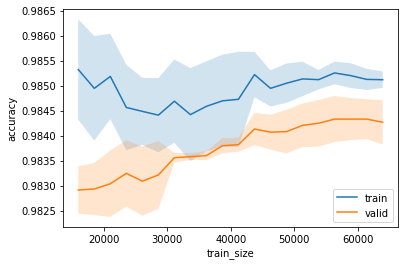

In [69]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.